In [78]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.measure import regionprops, label

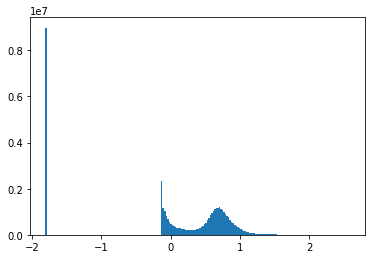

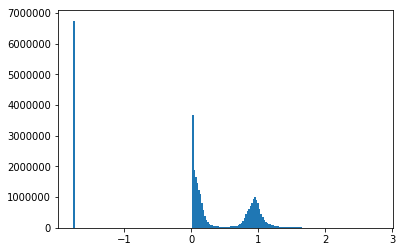

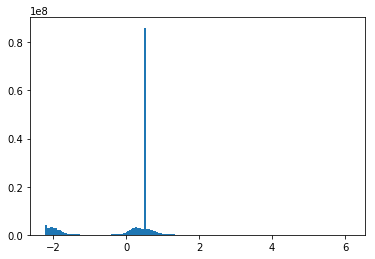

In [61]:
# load in file
def load_img(filename):
    itkimage = sitk.ReadImage(filename)
    numpy_image = sitk.GetArrayFromImage(itkimage) # z, y, x...
#     numpy_image = np.swapaxes(numpy_image, 0, 2)
    numpy_origin = np.array(itkimage.GetOrigin()) # x, y, z...
    numpy_spacing = np.array(itkimage.GetSpacing())
    return numpy_image, numpy_origin, numpy_spacing

# normalize method
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean)/std

# show distribution
def distribution(normalize_img):
    plt.hist(normalize_img.flatten(), bins = 200)
    plt.show()

# this one has strange distribution, not as cleanly separated
img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd')
distribution(normalize(img))

# this was the one with the slice with a black circular border, seems to not be different in 3d dist
img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
distribution(normalize(img))

# this was a normal one without black border
img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')
distribution(normalize(img))

-0.897444530568
0.372889487369


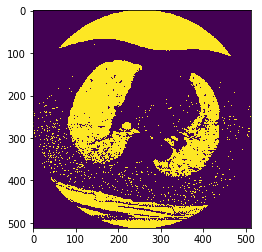

In [91]:
# proceed with k-means with k = 2 or k = 3, depending on if outliers exist
def convert_binary(norm_img):
    minimum = np.min(norm_img)
    num_near_min = norm_img[norm_img - minimum < 0.01].shape[0]
    total_count = norm_img.flatten().shape[0]
    if num_near_min/total_count > 0.1:
        kmeans = KMeans(n_clusters = 3, random_state = 0, n_init = 2, max_iter = 5).fit(norm_img.flatten().reshape(-1, 1))
    else:
        kmeans = KMeans(n_clusters = 2, random_state = 0, n_init = 1, max_iter = 1).fit(norm_img.flatten().reshape(-1, 1))
    centers = np.sort(kmeans.cluster_centers_.flatten())
    if centers.shape[0]==3:
        thresh_1 = (centers[0] + centers[1]) / 2
        print(thresh_1)
        thresh_2 = (centers[1] + centers[2]) / 2
        print(thresh_2)
        bin_img = np.where((norm_img < thresh_2) & (norm_img > thresh_1), 1.0, 0.0)
    else:
        thresh = (centers[0] + centers[1]) / 2
        bin_img = np.where(norm_img < thresh, 1.0, 0.0)
    plt.imshow(bin_img[int(0.5*bin_img.shape[0]), 0:512, 0:512])
    return bin_img
    
# this is the noisiest image
img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd')
bin_img = convert_binary(normalize(img))   

In [165]:
bi = np.copy(bin_img)

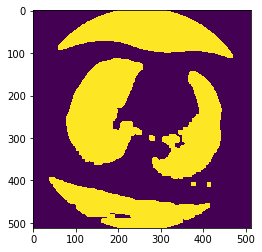

In [166]:
def make_regions(bin_img):
    for s in range(bin_img.shape[0]):
        s1 = bin_img[s,:,:]
        s2 = binary_erosion(s1, selem = np.ones([2, 2]))
        bin_img[s,:,:] = binary_dilation(s2, selem = np.ones([10, 10]))
    plt.imshow(bin_img[int(0.5*bin_img.shape[0]), 0:512, 0:512])
    return bin_img
    
x = make_regions(bi)

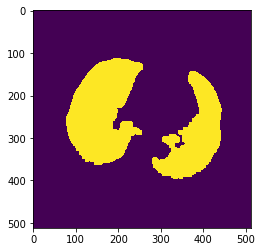

In [167]:
def mask(reg_img):
    mask = np.zeros(reg_img.shape)
    for s in range(reg_img.shape[0]):
        s1 = reg_img[s,:,:]
        props = regionprops(label(s1))
        labels = []
        for p in props:
            B = p.bbox
            if B[0] > 30 and B[2] < 470 and B[1] > 30 and B[3] < 470 and B[2] - B[0] > 50 and B[3] - B[1] > 50:
                labels.append(p.label)
        for l in labels:
            mask[s, :, :] = mask[s, :, :] + np.where(label(s1) == l, 1, 0)
    plt.imshow(mask[int(mask.shape[0]*0.5), 0:512, 0:512])
    return mask

m = mask(x)

TypeError: Invalid dimensions for image data

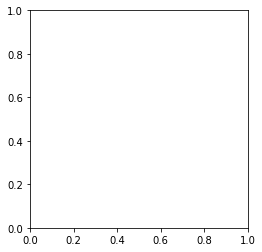

In [168]:
def mask_on_orig(original, mask):
    new_img = original * mask
    
    mean = np.mean(original[mask > 0])
    std = np.std(original[mask > 0])
    new_img = (new_img - mean)/std
    new_img[mask==0] = -5 # background = mean - 5 * std before normalization, highly unlikely to interfere
    
    plt.imshow(new_img)
    plt.show()
    plt.hist(new_img[int(new_img.shape[0]), 0:512, 0:512], bins=200)

img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd')
mask_on_orig(img, m)